In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mysql.connector
db=mysql.connector.connect(host="localhost",username="root",password="1234",database="ecommerce")
cur=db.cursor()

# List all unique cities where are customers are located.


In [10]:
query=""" select distinct (customer_city) from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Unique Cities"])

df.head()

,Unique Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of order placed in 2017. 

In [9]:
query=""" select count(order_id)from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
"Total order place in 2017 are ",data[0][0]

('Total order place in 2017 are ', 45101)

# Find the total sale per category.

In [7]:
query=""" select products.product_category category,
round(sum(payments.payment_value),2) sales
from products 
join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calucate the percentage of orders that were paid in stallments.

In [18]:
query=""" select sum(case when payment_installments>=1 then 1 
else 0 end)/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
"The percentage of orders that were paid in stallments is ",data[0][0]

('The percentage of orders that were paid in stallments is ',
 Decimal('99.9981'))

# Count the numbers customers from each state.

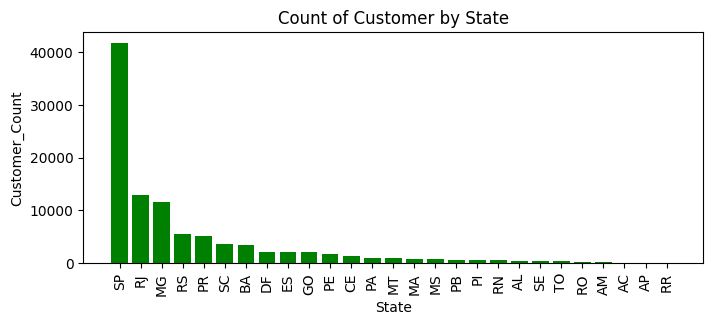

In [13]:
query=""" select customer_state ,count(customer_id) 
from customers group by customer_state 
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df["state"],df["customer_count"],color="green")
plt.xlabel("State")
plt.ylabel("Customer_Count")
plt.title("Count of Customer by State")
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per months in 2018.

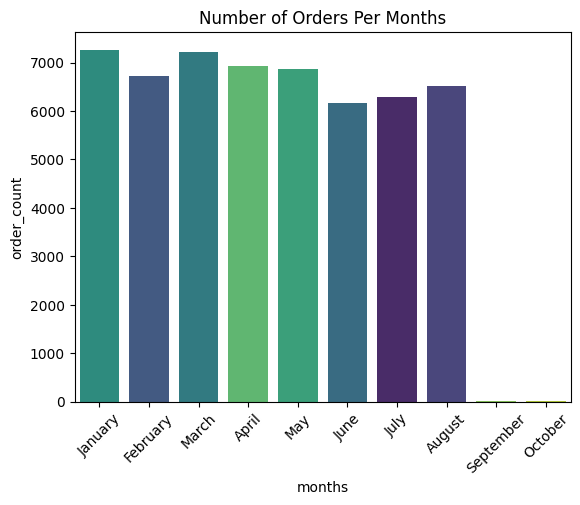

In [9]:
query=""" select monthname(order_purchase_timestamp) months ,
count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018 
group by months 
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]
sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o,hue=df["months"],palette="viridis")
plt.xticks(rotation=45)
plt.title("Number of Orders Per Months")
plt.show()

# Find the avarage number of products per order , group by customer city.

In [39]:
query="""  with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg (count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city 
  """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns = ["Customer_City","Average_Orders"])
df.head(10)

,Customer_City,Average_Orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


# Calculate the percentage of total reveue contributed by each product category.

In [11]:
query=""" select upper(products.product_category )category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments ))*100,2)
sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Percentage Distribution"])
df.head()

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has be purchased.


In [25]:
query=""" select products.product_category,count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Order_Count","Price"])
arr1=df["Order_Count"]
arr2=df["Price"]
a=np.corrcoef(arr1,arr2)
print("The correction between price and the number of times a product has be purchased is",a[0][-1])


The correction between price and the number of times a product has be purchased is -0.10631514167157562


# Calculate the total revenue generated by each sellers, and rank them by each revenue.

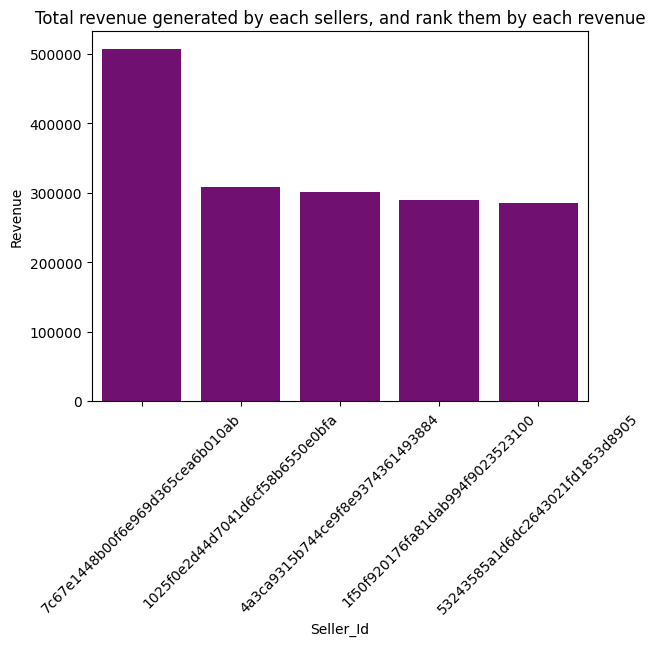

In [7]:
query="""  select *,dense_rank()over(order by revenue desc)as rn from
(select order_items.seller_id,sum(payments.payment_value)
revenue
from order_items join payments
on order_items.order_id =payments.order_id
group by order_items.seller_id)as a
  """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller_Id","Revenue","Rank"])
df=df.head()
sns.barplot(x = "Seller_Id",y = "Revenue",data = df,color="purple")
plt.xticks(rotation=45)
plt.title("Total revenue generated by each sellers, and rank them by each revenue")
plt.show()


Calculate the moving average of order for each customer over their order history.

In [8]:
query = """ select customer_id , order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as m
from
(select orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id)as a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Id","Date","Order_History","Moving_Average"])
df




,Id,Date,Order_History,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Write a cumulative sales per month for each year.

In [11]:
query = """ select years,months,payment,sum(payment)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years,months)as a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Months","Sales","Cumulative Sales"])
df.head(10)



,Years,Months,Sales,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year_over_year growth rate of total sales.

In [44]:
query = """with a as 
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years,((payment-lag(payment,1) over (order by years))/
lag(payment,1) over (order by years))*100  from a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","YOY % Growth"])
df

,Years,YOY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924
